# Suitability Project

Gabi Capone

16 November 2023

This notebook conducts suitability analysis for the ideal location of a new Whole Foods in Georgia based on income, population, and the distance from other Whole Foods stores.


The original source for the population and income data is the US Census Bureau's 2015-2019 American Community Survey five-year estimates. Locations of Whole Foods were gathered using Google Maps.

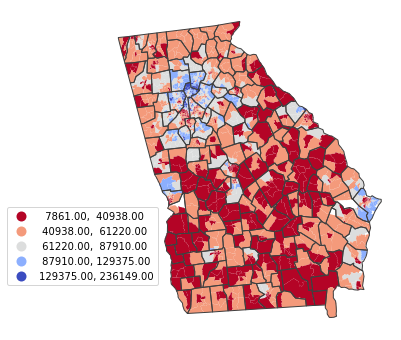

In [1]:
import pandas

import geopandas

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [9, 6]


tracts = geopandas.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-tracts.geojson")

tracts = tracts.to_crs("ESRI:102008")

tracts = tracts[~tracts["ST"].isin(['AK', 'HI', 'PR'])]

georgia_tracts = tracts[tracts["ST"] == "GA"]

georgia_counties = geopandas.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-counties.geojson")

georgia_counties = georgia_counties[georgia_counties.ST == "GA"]

georgia_counties = georgia_counties.to_crs(georgia_tracts.crs)


axis = georgia_tracts.plot("Median Household Income", scheme="naturalbreaks", 
	cmap="coolwarm_r", edgecolor="none", legend=True,
	legend_kwds={"bbox_to_anchor":(0.2, 0.4)})

georgia_counties.plot(facecolor="none", edgecolor="#404040", ax=axis)

axis.set_axis_off()

plt.show()

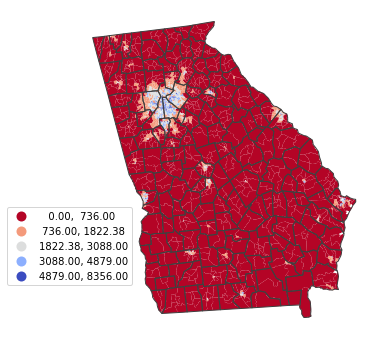

In [2]:
axis = georgia_tracts.plot("Pop per Square Mile", scheme="naturalbreaks", 
	cmap="coolwarm_r", edgecolor="none", legend=True,
	legend_kwds={"bbox_to_anchor":(0.2, 0.4)})

georgia_counties.plot(facecolor="none", edgecolor="#404040", ax=axis)

axis.set_axis_off()

plt.show()

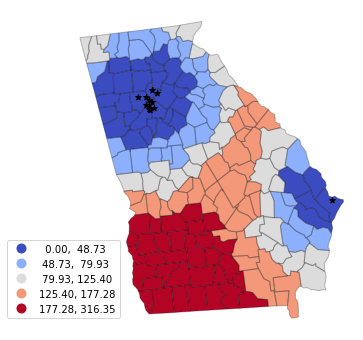

In [3]:
import pandas

csv = pandas.read_csv("https://github.com/gcapone2/cybergisx/raw/main/Whole%20Foods%20%20-%20Sheet1.csv")

points = geopandas.points_from_xy(csv["Longitude"], csv["Latitude"])

wf = geopandas.GeoDataFrame(csv, geometry = points, crs="EPSG:4326")

wf = wf.to_crs(georgia_counties.crs)

georgia_counties = georgia_counties.sjoin_nearest(wf, how="left", distance_col="wf_distance")

georgia_counties["wf_distance"] = georgia_counties["wf_distance"] / 1000

georgia_counties =georgia_counties.drop_duplicates("FactFinder GEOID")

georgia_counties= georgia_counties.drop("index_right", axis=1)

georgia_counties = georgia_counties.sort_values("wf_distance").reset_index(drop=True)

axis = georgia_counties.plot("wf_distance", cmap="coolwarm",
	legend=True, scheme="quantiles",
        legend_kwds={"bbox_to_anchor":(0.2, 0.3)})

georgia_counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)

wf.plot(marker="*", color="black", ax=axis)

axis.set_axis_off()
plt.show()

The first criteria used in this analysis is the distance from other Whole Foods. A distance greater than 27 miles to other Whole Foods locations is considered suitable for a new store to be located. 

Most counties that are 27 or more miles away from a Whole Foods are outside of the Atlanta metropolitan area. 

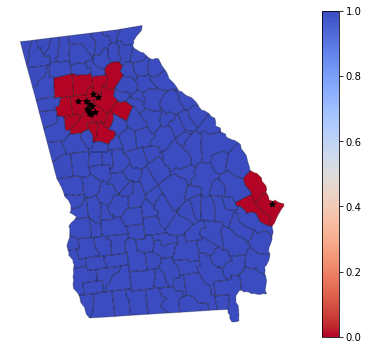

In [4]:
georgia_counties["Suitable Distance From Other Whole Foods"] = (georgia_counties["wf_distance"] > 27)

axis = georgia_counties.plot("Suitable Distance From Other Whole Foods", cmap="coolwarm_r",
	legend=True)

georgia_counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)

wf.plot(marker="*", color="black", ax=axis)

axis.set_axis_off()

plt.show()

Per [Business Insider](https://www.businessinsider.com/typical-whole-foods-shopper-demographic-millennial-woman-earning-middle-income-2021-8), the typical Whole Foods shopper earns around $80,000 a year. 

As a result, a suitable median houshold income for a given Georgia county should be greater than or equal to $80,000.

Few counties meet this criteria, they are Columbia, Forsynth, Cherokee, Oconee, and Fayette.

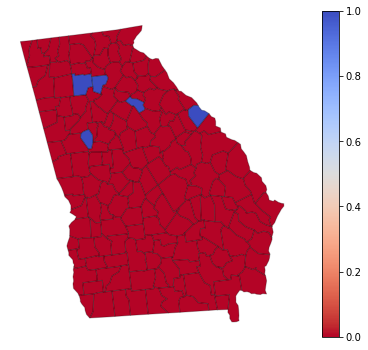

In [5]:
georgia_counties["Suitable Customer Income"] = (georgia_counties["Median Household Income"] >= 80000)

axis = georgia_counties.plot("Suitable Customer Income", cmap="coolwarm_r",
	legend=True)

georgia_counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)

axis.set_axis_off()

plt.show()

According to [World Population Review](https://worldpopulationreview.com/states/georgia-population), the average population per square mile in Georgia, US, is 168.4. 

Using this number as a threshold for counties with suitable populations, a large amount of fitting counties lie in a broad area around Atlanta. 

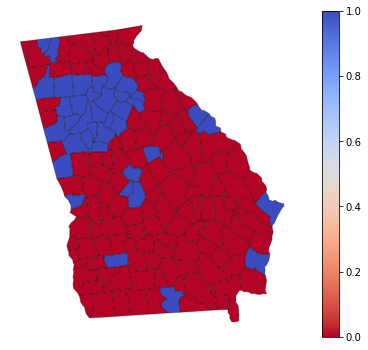

In [6]:
georgia_counties["Suitable County Population"] = (georgia_counties["Pop per Square Mile"] >= 168.4 )

axis = georgia_counties.plot("Suitable County Population", cmap="coolwarm_r",
	legend=True)

georgia_counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)

axis.set_axis_off()

plt.show()

Putting all the criteria together, the three counties that fit income, population, and distance thresholds are Fayette, Oconee, and Columbia.

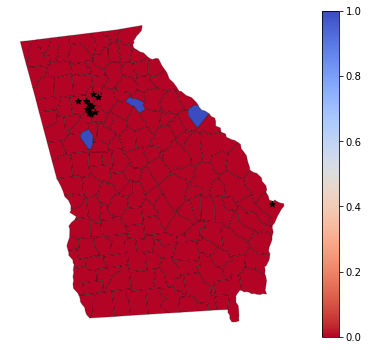

In [7]:
georgia_counties["Categorical Suitability"] = georgia_counties["Suitable Customer Income"] & \
                georgia_counties["Suitable County Population"] & georgia_counties["Suitable Distance From Other Whole Foods"]

axis = georgia_counties.plot("Categorical Suitability", cmap="coolwarm_r",
        legend=True)

georgia_counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)

wf.plot(marker="*", color="black", ax=axis)

axis.set_axis_off()

plt.show()

In [8]:
list_counties = georgia_counties[georgia_counties["Categorical Suitability"]]

list_counties["Name"]

17      Fayette
32       Oconee
120    Columbia
Name: Name, dtype: object

For the weighted analysis, the variable of income index was given a weight of 0.4. Similarly, variable of population index was given a weight of 0.4. The variable of distance from other Whole Foods stores was only given a weight of 0.2 as many of their locations are closer together, yet Whole Foods maintains a sucessful business model. 

Two counties deemed the most suitable for the new location of a Whole Foods in Georgia are DeKalb and Cobb. 

The analysis outlined in this notebook can help inform Whole Foods ideal locations for a new Whole Foods in Georgia based on factors of income, population, and distance from other stores.  

In [9]:
georgia_counties["income_index"] = (georgia_counties["Median Household Income"] - min(georgia_counties["Median Household Income"])) / \
			(max(georgia_counties["Median Household Income"]) - min(georgia_counties["Median Household Income"]))

georgia_counties["pop_index"] = (georgia_counties["Pop per Square Mile"] - min(georgia_counties["Pop per Square Mile"])) / \
			(max(georgia_counties["Pop per Square Mile"]) - min(georgia_counties["Pop per Square Mile"]))

georgia_counties["wf_distance"] = (georgia_counties["wf_distance"] - min(georgia_counties["wf_distance"])) / \
			(max(georgia_counties["wf_distance"]) - min(georgia_counties["wf_distance"]))


georgia_counties["Weighted Suitability"] = (0.40 * georgia_counties["income_index"]) + \
		(0.40 *georgia_counties["pop_index"]) + \
		(0.20 * georgia_counties["wf_distance"])

georgia_counties = georgia_counties.sort_values("Weighted Suitability", ascending=False).reset_index(drop=True)

georgia_counties[["Name", "Weighted Suitability"]].head()

,Name,Weighted Suitability
0,DeKalb,0.588821
1,Cobb,0.577854
2,Forsyth,0.546849
3,Gwinnett,0.534303
4,Fulton,0.504038


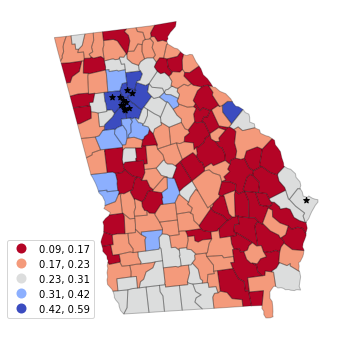

In [10]:
axis = georgia_counties.plot("Weighted Suitability", cmap="coolwarm_r",
	legend=True, scheme="naturalbreaks",
        legend_kwds={"bbox_to_anchor":(0.2, 0.3)})

georgia_counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)

wf.plot(marker="*", color="black", ax=axis)

axis.set_axis_off()

plt.show()